# Uniper Account Classification

In [4]:
! pip install python-docx
! pip install dill

     |████████████████████████████████| 86 kB 3.0 MB/s 


In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions
import pickle
from datetime import date
from pathlib import Path
import zipfile
from zipfile import ZipFile
import dill as pkl
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import json
%matplotlib inline

TODAY = date.today().strftime("%Y%m%d")
CLIENT = "Uniper"
MIN_NUM_OF_SAMPLES = 5
COUNTRY = 'DE'  # possible choices: DE, UK, AT, SE, UBX
SAVE_CLFS = True
PREDICTIONS_EXCEL = False
RES_DIR = Path(f"./retraining_october21/{COUNTRY.lower()}")
SCAN_ID_COL = "gl_document_scan_id"  # document identifier col used when reducing
                                     # global df to relevant examples for attribute

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [7]:
# %load training_utils.py
"""This file contains helper functionality to train/evaluate models
   and create reports"""

import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions


def reduce_to_relevant(df: DataFrame, col: str, min_num_samples: int) -> DataFrame:
    """Reduces df to instances with values in col that appear at least
       min_num_samples times and returns reduced df.

    Args:
        df (DataFrame): Input DataFrame.
        col (str): Name of the column that holds the feature of interest.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'col'
            that appear more than 'min_num_samples' times.

    """
    # find rows for values that appear at least min_num_samples times
    relevant = [x for x in df[col].value_counts().index
                if df[col].value_counts()[x] >= min_num_samples]
    # create boolean mask
    mask = [(x in relevant) for x in df[col]]

    print(
        f"Reduced to {len(df[mask])} samples from {len(relevant)} relevant classes. (N={min_num_samples})"
    )

    return df[mask]


def get_reduced_df(
        df: DataFrame,
        feature_col: str,
        scan_id_col: str,
        min_num_samples: int) -> DataFrame:
    """Drops duplicates and reduces df to relevant examples that appear
       at least min_num_samples times and are unambiguous.

    Args:
        df (DataFrame): Input DataFrame.
        feature_col (str): Name of the column that holds the feature of interest.
        scan_id_col (str): Name of the column that holds the unique
            document identifier.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'feature_col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'feature_col'
            that appear more than 'min_num_samples' times and are unambiguous.

    """
    # keep only documents with unambiguous value for this col
    df_ = df.drop_duplicates(subset=[scan_id_col, feature_col])\
            .groupby(scan_id_col)\
            .filter(lambda x: len(x) == 1)

    return reduce_to_relevant(df_, feature_col, min_num_samples)


def split_for_target_col(df, col, test_size=0.2, random_state=666):
    """
    Performs train test split with specified col as target variable.
    Returns: X_train, X_test, y_train, y_test
    """
    return train_test_split(
        df,
        df[col],
        test_size=test_size,
        random_state=random_state
    )


def _get_top_n_results_with_confs(
        clazzes: Sequence[str],
        probs: List[float],
        n: int = 1) -> List[Tuple[str, float]]:
    """Constructs list of (class, proba) tuples for top n results.

    Args:
        clazzes (Sequence[str]): Sequence of class names as stored in
            clf.classes_ attribute of sklearn classifier.
        probs (List[float]): List with probabilities for each class in clazzes.
        n (int): Number of most probable results to return. Defaults to 1.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for top n results.

    """
    return sorted(
        zip(clazzes, probs),
        key=lambda x: x[1],
        reverse=True
    )[:n]


def get_results_for_target(
        target_clf: Any,
        df: DataFrame) -> List[Tuple[str, float]]:
    """Computes predictions with provided classifier on DataFrame df.

    Args:
        target_clf (Any): Sklearn classifier that offers 'predict_proba()'.
        df (DataFrame): Input DataFrame as expected by 'target_clf'.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for
            instances in df.

    """
    probs = target_clf.predict_proba(df)
    clazzes = target_clf.classes_
    results = []
    for prob_list in probs:
        results.append(_get_top_n_results_with_confs(clazzes, prob_list)[0])
    return results


def _get_text_col_from_df(df: DataFrame):
    return df['text']


def save_clf_to_disk(
        clf,
        attribute_name: str,
        folder: Path,
        date: str,
        client: str,
        country: str,
        min_num_samples: int,
        add_zip=True) -> None:

    # safe to pkl with full info in file name
    pkl_path = folder / f"{date}_{client}_clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl"
    with open(pkl_path, 'wb') as file:
        pkl.dump(clf, file)

    if add_zip:
        # create zip with non changing name for easy deployment
        zip_path = folder / f"clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl.zip"
        with ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as file:
            # second argument avoids recreation of folder structure in zip-archive
            file.write(pkl_path, pkl_path.parts[-1])


def enrich_kw_list(kw_list):
    """Enriches keywords by replacing street names with possible synonyms. Since we demand ALL keywords to
       be found for a positive match, this function returns a list of keyword lists, one for every possible
       synonym.
    
    """
    new_kw_lists = [kw_list]
    street_synonyms = ["str.", "strasse", "straße"]
    for street_syn in street_synonyms:
        remaining_syns = [x for x in street_synonyms if x != street_syn]
        if any(street_syn in kw for kw in kw_list):
            new_kw_lists += [[kw.replace(street_syn, synonym) for kw in kw_list] for synonym in remaining_syns]
    return new_kw_lists


In [9]:
%load_ext autoreload
%autoreload 2

In [8]:
tday = date.today().strftime("%A %d. %B %Y") 
print(f"Models trained on {tday} with package versions: \n")
print(f"scikit-learn: {sklearn.__version__}")
print(f"dill: {pkl.__version__}")

Models trained on Sunday 06. February 2022 with package versions: 

scikit-learn: 0.24.1
dill: 0.3.4


In [10]:
# dicts used to restrict ground truth later
country_group_to_countries = {
    "DE": ["DE"],
    "SE": ["SE"],
    "AT": ["AT"],
    "UK": ["GB"],
    "UBX": ["BE", "NL", "LU"]    
}

In [11]:
pickle_texts = "/Users/rampageyao/Desktop/KPMG Work/KPMG/Multiple_Classification/texts_all_rt202110.pkl"
uniper =  "/Users/rampageyao/Desktop/KPMG Work/KPMG/Multiple_Classification/Uniper_GT_09_21.xlsx"
sc21_json = "/Users/rampageyao/Desktop/KPMG Work/KPMG/Multiple_Classification/sc21v8.json"

with open(pickle_texts, "rb") as file:
    df_lume = pickle.load(file)
df_lume.drop_duplicates(inplace=True)
print(df_lume.shape)

df_ground_truth = pd.read_excel(uniper)
len(df_ground_truth)

df_ground_truth.dropna(subset=[SCAN_ID_COL], inplace=True)
df_ground_truth[SCAN_ID_COL] = df_ground_truth[SCAN_ID_COL].apply(lambda x: x.lower())

len(df_ground_truth[SCAN_ID_COL].unique())
df_merged = df_lume.merge(df_ground_truth, left_on=["filename"], right_on=[SCAN_ID_COL], how="inner")

df_merged.drop_duplicates(inplace=True)
df_merged.shape

# add left-hand zeros to gl_legal_entity_id, gl_accounts_id, gl_vendor_id
df_merged['gl_legal_entity_id'] = df_merged['gl_legal_entity_id'].apply(lambda x: str(int(x)).zfill(4))
df_merged['gl_accounts_id'] = df_merged['gl_accounts_id'].apply(lambda x: str(int(x)).zfill(10))
df_merged['gl_vendor_id'] = df_merged['gl_vendor_id'].apply(lambda x: str(int(x)).zfill(10))

# restict to respective country(group)
df = df_merged[
    df_merged['le_country_id'].isin(country_group_to_countries[COUNTRY])
]

df['le_country_id'].value_counts()

df['gl_posting_id'] = df['gl_posting_id'].apply(lambda x: str(int(x)))

dft = get_reduced_df(df, 'gl_posting_id', SCAN_ID_COL, MIN_NUM_OF_SAMPLES)
dft[dft['gl_posting_id'] == '50']
df[['gl_legal_entity_id', 'gl_accounts_id', 'gl_cost_center_id', 'gl_wbs_element_id', 'gl_vendor_id']]

(160704, 2)


<ipython-input-11-01e96514ece6>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gl_posting_id'] = df['gl_posting_id'].apply(lambda x: str(int(x)))


Reduced to 32962 samples from 3 relevant classes. (N=5)


,gl_legal_entity_id,gl_accounts_id,gl_cost_center_id,gl_wbs_element_id,gl_vendor_id
0,0037,1734082001,0000037001,NaN,0002000582
1,0037,1734934025,0000037001,NaN,0002449868
2,0037,1734067004,0000037001,NaN,0002053354
3,0037,1734934001,0000037001,NaN,0001000092
4,0037,1734030000,0000037001,NaN,0001257969
...,...,...,...,...,...
90275,9370,1734999000,2937052000,NaN,0002006228
90276,9370,1734940001,2937060000,NaN,0001435553
90277,9370,1734934012,2937039200,NaN,0002037197
90278,9370,1734950002,2937059000,NaN,0002479202


In [12]:
with open(sc21_json, 'r') as file:
    mapping_json = json.load(file)

enrich_kw_list(["a", "b", "heinestrasse"])

# apply mapping if df contains any of the relevant legeal entity ids

remapped_docs = []

if any([key in df['gl_legal_entity_id'].unique() for key in mapping_json.keys()]):
    
    #print("Starting to apply remapping script...")
    
    type_to_col = {
        'psp': 'gl_wbs_element_id',
        'cc': 'gl_cost_center_id',
        None: ['gl_cost_center_id', 'gl_order_id', 'gl_wbs_element_id']
    }

    # from collections import defaultdict
    # old_vals = defaultdict(list)
    # new_vals = defaultdict(list)

    for legal_entity, mapping_list in mapping_json.items():
        for mapping in mapping_list:

            gl_acc, old_value, old_type, new_value, new_type, gl_vend, keywords = mapping

            if old_value is None:
                continue
                
            # added 20211021
            if old_type is None and new_type is None:
                continue

            # fill up with left hand zeros
            # gl account auch mit 0 füllen???
            if old_type == 'cc':
                old_value = old_value.zfill(10)
            if new_type == 'cc':
                new_value = new_value.zfill(10)
            if gl_vend is not None:
                gl_vend = gl_vend.zfill(10)

            old_col = type_to_col[old_type]
            new_col = type_to_col[new_type]

            # create filter mask
            if old_value == '*':
                mask = (df['gl_legal_entity_id'] == legal_entity) \
                    & (df['gl_accounts_id'] == gl_acc)
            else:
                #print(f"legal entity {legal_entity}, mapping {mapping}")
                mask = (df['gl_legal_entity_id'] == legal_entity) \
                    & (df['gl_accounts_id'] == gl_acc) \
                    & (df[old_col] == old_value)

            if gl_vend is not None:
                mask = mask & (df['gl_vendor_id'] == gl_vend)

            if keywords:
                kw_lists = enrich_kw_list(keywords)
                kw_mask = df['text'].apply(
                    lambda text: any([all([kw in text for kw in kws]) for kws in kw_lists])
                )
                mask = mask & kw_mask

            # set new values, override old ones if necessary
            if not df.loc[mask].empty:
                #print(f'found value {old_value} of type {old_type} for legal entity {legal_entity}')
                if old_col == new_col:
    #                 print('old_col == new_col')
                    df.loc[mask, new_col] = new_value
    #                 old_vals[legal_entity].append(old_value)
    #                 new_vals[legal_entity].append(new_value)
                else:
    #                 print('old_col != new_col')
                    df.loc[mask, old_col] = np.nan
                    df.loc[mask, new_col] = new_value
                
                if isinstance(df.loc[mask, SCAN_ID_COL], str):
                    remapped_docs.append(df.loc[mask, SCAN_ID_COL])
                else:
                    remapped_docs += list(df.loc[mask, SCAN_ID_COL])
                
    print(f"finished remapping, writing {SCAN_ID_COL} of mapped invoices to excel file")
    pd.DataFrame.from_dict({SCAN_ID_COL: list(set(remapped_docs))})\
            .to_excel(RES_DIR / f"{TODAY}_{CLIENT}_remapped_invoices.xlsx", index=False)

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


finished remapping, writing gl_document_scan_id of mapped invoices to excel file


In [14]:
# Runyao's update
def get_certain_class_after_vec_country(df_lume, label):
    label = label
    df_attr = get_reduced_df(df_lume, label, SCAN_ID_COL, MIN_NUM_OF_SAMPLES)
    x_train, x_test, y_train, y_test = split_for_target_col_stratified(df_attr, label)
    vectorizer = TfidfVectorizer(max_features=20000, max_df=0.75, sublinear_tf=True,)
    X_train = x_train['text']
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test = x_test['text']
    X_test_vec = vectorizer.transform(X_test)
    return x_train, x_test, y_train, y_test, X_train_vec, X_test_vec


def split_for_target_col_stratified(df, col, test_size=0.2, random_state=42,):
    return train_test_split(df,
        df[col],
        test_size=test_size,
        random_state=random_state,
        stratify=df[col]
    )


def train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl):

    model.fit(X_train_vec, y_train)
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    if save_pkl == True:
      pkl_path = "/Users/rampageyao/Downloads/retraining_october21/model.pkl"
      with open(pkl_path, "wb") as file:
        pkl.dump(model, file)

    print(model.best_params_)
    print(model.best_score_)
    print("Training Accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
    print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_test_pred)))

    print(classification_report(y_test, y_test_pred))

    # confusion matix
    conf_train = confusion_matrix(y_train, y_train_pred)
    conf_test = confusion_matrix(y_test, y_test_pred)

    fg, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(conf_train, annot=True, fmt="d", ax=ax1)
    ax1.set(xlabel="predicted label")
    ax1.set(ylabel="actual label")
    #ax1.set_xticklabels(['0','1'])
    #ax1.set_yticklabels(['0','1'])
    ax1.set(title="Confusion Matrix for training set")

    sns.heatmap(conf_test, annot=True, fmt="d", ax=ax2)
    ax2.set(xlabel="predicted label")
    ax2.set(ylabel="actual label")
    #ax2.set_xticklabels(['0','1'])
    #ax2.set_yticklabels(['0','1'])
    ax2.set(title="Confusion Matrix for test set")


In [24]:
from sklearn.svm import SVC

def train_model(label, save_pkl=False):
  x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_gl_id, label)

  svm = SVC(random_state=42) 
  parameters = {'kernel': ['rbf'], 'gamma': ['scale']}
  model = GridSearchCV(svm, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
  #model.get_params().keys()
  train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl)

# gl_accounts_id

In [19]:
df_gl_id = get_reduced_df(df, 'gl_accounts_id', SCAN_ID_COL, MIN_NUM_OF_SAMPLES)

Reduced to 28168 samples from 176 relevant classes. (N=5)


Reduced to 28168 samples from 176 relevant classes. (N=5)
Fitting 10 folds for each of 4 candidates, totalling 40 fits


/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


{'gamma': 'scale', 'kernel': 'rbf'}
0.7624035152183957
Training Accuracy: 0.884
Test Accuracy: 0.759
              precision    recall  f1-score   support

  1161182000       0.67      0.33      0.44         6
  1200100001       0.70      0.67      0.69        73
  1200200001       1.00      0.27      0.42        15
  1200300001       1.00      0.93      0.96        14
  1240301000       0.50      0.40      0.44         5
  1240304000       0.70      0.18      0.29        39
  1261184001       1.00      1.00      1.00         6
  1540002001       0.78      0.88      0.83       138
  1561171002       1.00      0.50      0.67         2
  1600003000       1.00      0.40      0.57         5
  1600006003       1.00      1.00      1.00         2
  1600199008       1.00      0.83      0.91         6
  1600798000       0.78      1.00      0.88         7
  1625000001       1.00      1.00      1.00        18
  1625014000       0.83      0.71      0.77         7
  1625014001       0.89      0.80 

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


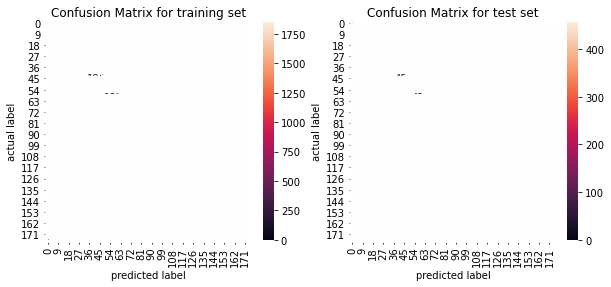

In [20]:
label = 'gl_accounts_id' # define label here
train_model(label)

# gl_legal_entity_id

Reduced to 28164 samples from 21 relevant classes. (N=5)
Fitting 10 folds for each of 2 candidates, totalling 20 fits
{'gamma': 'scale', 'kernel': 'rbf'}
0.9469175871587563
Training Accuracy: 0.987
Test Accuracy: 0.951
              precision    recall  f1-score   support

        0037       1.00      1.00      1.00        56
        0065       0.97      0.98      0.97       299
        0301       0.91      0.98      0.94      1574
        0303       0.97      0.99      0.98      1216
        0330       0.91      0.91      0.91       314
        0362       0.99      0.89      0.94       109
        0377       1.00      0.94      0.97        32
        0601       0.98      0.90      0.94       292
        0801       0.97      0.95      0.96       898
        0806       1.00      0.86      0.92        42
        0811       1.00      0.42      0.59        12
        0821       0.98      0.95      0.96       209
        2101       0.99      0.96      0.97       260
        2111       0.99 

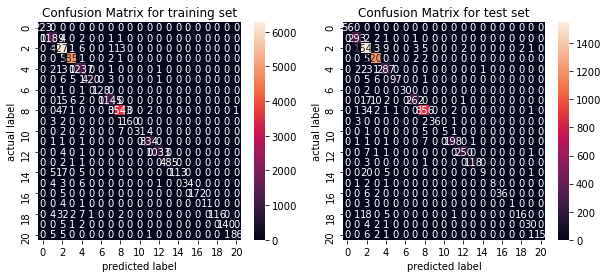

In [22]:
label = 'gl_legal_entity_id' # define label here
train_model(label, save_pkl=True)

# gl_tax_code_id

Reduced to 27886 samples from 32 relevant classes. (N=5)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


{'gamma': 'scale', 'kernel': 'rbf'}
0.8916081790827576
Training Accuracy: 0.953
Test Accuracy: 0.900
              precision    recall  f1-score   support

          0W       1.00      0.80      0.89        10
          11       0.80      0.86      0.83        37
          51       0.90      0.98      0.93      3399
          52       0.91      0.70      0.79       550
          53       0.72      0.61      0.66       183
          54       0.00      0.00      0.00         3
          56       1.00      0.04      0.07        27
          80       0.96      0.99      0.97       484
          99       0.92      0.81      0.86       569
          A1       0.00      0.00      0.00         7
          B2       0.00      0.00      0.00         1
          C2       0.83      0.81      0.82        62
          C3       1.00      0.75      0.86        20
          C6       1.00      1.00      1.00        25
          C8       1.00      0.33      0.50         3
          CB       0.00      0.00 

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


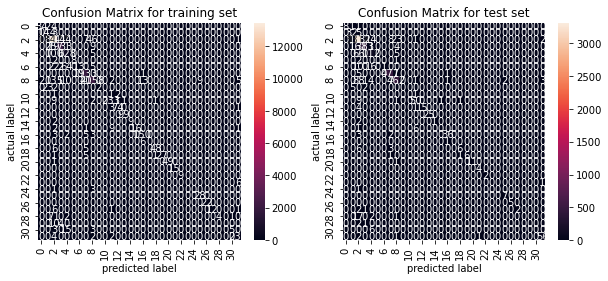

In [23]:
label = 'gl_tax_code_id' # define label here
train_model(label)

In [32]:
label = 'gl_vendor_id' # define label here
train_model(label)

Reduced to 23189 samples from 768 relevant classes. (N=5)
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


{'gamma': 'scale', 'kernel': 'rbf'}
0.9606487591783622
Training Accuracy: 0.985
Test Accuracy: 0.965
              precision    recall  f1-score   support

  0001000007       0.83      1.00      0.91        10
  0001000008       0.00      0.00      0.00         2
  0001000074       1.00      1.00      1.00        68
  0001000075       1.00      1.00      1.00         3
  0001000085       0.98      0.98      0.98        41
  0001000089       1.00      1.00      1.00       285
  0001000092       1.00      1.00      1.00       101
  0001000275       1.00      1.00      1.00        19
  0001000281       1.00      1.00      1.00         5
  0001000282       1.00      1.00      1.00        11
  0001000283       1.00      0.71      0.83         7
  0001000284       1.00      1.00      1.00        19
  0001000305       1.00      1.00      1.00         3
  0001000538       0.00      0.00      0.00         1
  0001000539       1.00      1.00      1.00         2
  0001001026       1.00      0.94 

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train cost element classifiers per company code

## Prepare Data

In [25]:
# Prepare cost element column

df_kostenstelle = df[df['gl_cost_center_id'].notna()]
df_kostenstelle['Target'] = df_kostenstelle['gl_cost_center_id']

df_psp = df[df['gl_wbs_element_id'].notna()]
df_psp['Target'] = df_psp['gl_wbs_element_id']

df_auftrag = df[df['gl_order_id'].notna()]
df_auftrag['Target'] = df_auftrag['gl_order_id']

df_pka = pd.concat([df_auftrag,df_kostenstelle, df_psp], axis=0)
df_pka['Target'] = df_pka['Target'].apply(lambda x: str(x))

df_pka.dropna(subset=['text'], inplace=True)
df_pka.drop_duplicates(subset=['text'], inplace=True)

len(df_pka),len(df_pka['text'].unique())

<ipython-input-25-2aa222950042>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kostenstelle['Target'] = df_kostenstelle['gl_cost_center_id']
<ipython-input-25-2aa222950042>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_psp['Target'] = df_psp['gl_wbs_element_id']
<ipython-input-25-2aa222950042>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

(31656, 31656)

In [26]:
with open("/Users/rampageyao/Downloads/retraining_october21/model.pkl", "rb") as file:
    clf_bukr = pkl.load(file)

## Train classifiers (always uses N=1 here)

In [27]:
local_min_num = 1

for company_code in clf_bukr.classes_:
    df_cost_elem = df_pka[df_pka["gl_legal_entity_id"] == company_code]
    num_classes = len(df_cost_elem["Target"].unique())
    #print(f"company code {str(company_code).zfill(4)}: {len(df_cost_elem)} entries for {num_classes} classes")

In [29]:
def train_com_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl):
    model.fit(X_train_vec, y_train)
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    if save_pkl == True:
      pkl_path = "/content/retraining_october21/model.pkl"
      with open(pkl_path, "wb") as file:
        pkl.dump(model, file)

    print("Training Accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
    print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_test_pred)))
    print(classification_report(y_test, y_test_pred))

In [30]:
def train_com_model(label, save_pkl=False):
    x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_ce, label)
    model = SVC(kernel='rbf', gamma='scale',random_state=42) 
    train_com_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl)

In [31]:
for company_code in clf_bukr.classes_:
    print(f"Company Code: {str(company_code).zfill(4)}" + "\n")
    # reduce dataframe to entries for fixed company code
    df_cost_elem = df_pka[df_pka["gl_legal_entity_id"] == company_code]
    
    print("Cost Element classification:")
    # reduce to relevant samples
    df_ce = reduce_to_relevant(df_cost_elem, "Target", min_num_samples=local_min_num)
    
    if df_ce.shape[0] == 0:  # do not proceed if df is empty
        print(20 * "-" + "\n")
        continue
    train_com_model('Target')
    
    print(20 * "-" + "\n")

Company Code: 0037

Cost Element classification:
Reduced to 279 samples from 6 relevant classes. (N=1)
Reduced to 271 samples from 2 relevant classes. (N=5)
Training Accuracy: 0.940
Test Accuracy: 0.945
              precision    recall  f1-score   support

  0000037001       0.95      1.00      0.97        52
  0000037330       0.00      0.00      0.00         3

    accuracy                           0.95        55
   macro avg       0.47      0.50      0.49        55
weighted avg       0.89      0.95      0.92        55

--------------------

Company Code: 0065

Cost Element classification:
Reduced to 1721 samples from 174 relevant classes. (N=1)
Reduced to 1498 samples from 37 relevant classes. (N=5)


/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.967
Test Accuracy: 0.817
                          precision    recall  f1-score   support

0065.1206O3.201.00.10.03       0.91      1.00      0.95        10
0065.1206O3.201.00.10.06       1.00      0.50      0.67         2
0065.1206OA.203.00.10.02       0.00      0.00      0.00         1
0065.1206OA.203.00.10.07       1.00      0.40      0.57         5
0065.1206OA.203.00.10.08       0.00      0.00      0.00         4
0065.1206OA.203.00.10.14       0.60      1.00      0.75         3
0065.1206OA.207.00.10.07       0.67      0.50      0.57         4
0065.1206OA.207.00.10.08       0.00      0.00      0.00         1
0065.1206OA.208.00.10.07       1.00      1.00      1.00         4
0065.1209FA.220.00.97.11       1.00      1.00      1.00        12
0065.1602JA.206.00.60.10       0.00      0.00      0.00         1
0065.1608FA.200.00.00.10       0.00      0.00      0.00         2
0065.1613OA.202.05.69.10       1.00      1.00      1.00         1
0065.SALCOM.200.00.10.10     

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 7176 samples from 782 relevant classes. (N=1)
Reduced to 6173 samples from 238 relevant classes. (N=5)
Training Accuracy: 0.906
Test Accuracy: 0.731
                          precision    recall  f1-score   support

              0010100902       0.93      1.00      0.96        26
              0010100950       0.00      0.00      0.00         1
              0011100810       0.00      0.00      0.00         3
              0012000163       0.78      0.70      0.74        10
              0012000355       0.00      0.00      0.00         4
              0012000580       1.00      1.00      1.00         1
              0012000591       0.00      0.00      0.00         1
              0012000603       1.00      1.00      1.00         2
              0012006201       0.00      0.00      0.00         2
              0022100133       0.00      0.00      0.00         1
              0028000020       0.00      0.00      0.00         4
              0028000050       0.56      0.62  

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 8809 samples from 1207 relevant classes. (N=1)
Reduced to 7314 samples from 350 relevant classes. (N=5)
Training Accuracy: 0.719
Test Accuracy: 0.465
                    precision    recall  f1-score   support

        0110110000       0.83      0.67      0.74        15
        0110510000       1.00      0.50      0.67         8
        0111510000       0.75      0.75      0.75         4
        0112010000       1.00      0.77      0.87        13
        0112510000       1.00      0.79      0.88        14
        0114010000       1.00      0.50      0.67         2
        0121014000       0.75      1.00      0.86         6
        0121515000       1.00      0.83      0.91         6
        0121520500       0.00      0.00      0.00         1
        0122010000       0.75      0.57      0.65        21
        0122015000       1.00      1.00      1.00         1
        0122015200       0.00      0.00      0.00         2
        0122015300       1.00      0.83      0.91        1

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 1501 samples from 61 relevant classes. (N=5)
Training Accuracy: 0.912
Test Accuracy: 0.671
                       precision    recall  f1-score   support

   0330.Y12100.004.02       1.00      1.00      1.00         1
   0330.Y12100.004.03       1.00      1.00      1.00         4
   0330.Y12100.004.05       1.00      1.00      1.00         1
   0330.Y12100.004.08       1.00      0.33      0.50         3
   0330.Y12100.004.12       1.00      1.00      1.00         5
   0330.Y12100.004.16       0.00      0.00      0.00         2
   0330.Y12100.004.19       0.00      0.00      0.00         1
   0330.Y12100.004.20       0.00      0.00      0.00         2
      0330.Y12100.005       0.86      0.50      0.63        12
   0330.Y12100.008.01       0.00      0.00      0.00         1
   0330.Y12210.009.01       0.00      0.00      0.00         1
   0330.Y12210.009.02       0.50      0.50      0.50         2
      0330.Y12210.111       1.00      0.67      0.80         3
0330.Y12807.001

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.945
Test Accuracy: 0.800
                    precision    recall  f1-score   support

        0015030020       1.00      0.33      0.50         3
        0015030030       0.00      0.00      0.00         3
        0015030050       0.65      0.87      0.74        30
        0015030065       0.50      0.25      0.33         4
        0015030070       1.00      1.00      1.00         1
        0015076001       0.67      1.00      0.80         4
        0015097101       0.00      0.00      0.00         2
        0015098103       0.91      1.00      0.95        10
0362.G62000.088.55       0.67      1.00      0.80         4
0362.G62000.092.58       0.00      0.00      0.00         2
0362.G62000.093.58       1.00      1.00      1.00         1
0362.G62000.095.01       0.00      0.00      0.00         1
0362.G62000.096.58       1.00      1.00      1.00        28
0362.G62000.999.30       1.00      0.80      0.89         5
0362.G63000.082.55       0.75      1.00      0.86    

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Reduced to 1913 samples from 62 relevant classes. (N=5)
Training Accuracy: 0.882
Test Accuracy: 0.710
                    precision    recall  f1-score   support

        0090022015       1.00      1.00      1.00         6
        0090024002       1.00      1.00      1.00         1
        0090024009       1.00      1.00      1.00         2
        0090026700       0.00      0.00      0.00         2
        0090026810       0.00      0.00      0.00         3
        0090030010       1.00      1.00      1.00         1
        0090030020       0.80      0.44      0.57         9
        0090032010       0.91      1.00      0.95        21
        0090032042       1.00      0.77      0.87        13
        0090034032       1.00      0.73      0.84        11
        0090034035       0.81      0.76      0.79        17
        0090034038       0.00      0.00      0.00         2
        0090034041       0.67      0.67      0.67         3
        0090036150       0.65      0.92      0.76       

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 4789 samples from 568 relevant classes. (N=1)
Reduced to 4015 samples from 163 relevant classes. (N=5)
Training Accuracy: 0.893
Test Accuracy: 0.725
                       precision    recall  f1-score   support

           0000010240       0.00      0.00      0.00         1
           0000011440       1.00      1.00      1.00         1
           0000012140       1.00      1.00      1.00         1
           0000018010       1.00      0.33      0.50         3
           0000040340       0.00      0.00      0.00         2
           0000040440       0.00      0.00      0.00         1
           0000040540       0.00      0.00      0.00         1
           0000041340       0.00      0.00      0.00         1
           0000041640       0.00      0.00      0.00         1
           0000042040       0.25      0.33      0.29         3
           0000042240       0.00      0.00      0.00         1
           0000045841       0.00      0.00      0.00         2
           000004701

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.975
Test Accuracy: 0.829
                 precision    recall  f1-score   support

     0000068000       0.81      1.00      0.90        26
     0000068100       1.00      1.00      1.00         2
     0000069000       1.00      0.60      0.75         5
0806.A68009.950       0.50      1.00      0.67         1
0806.S60000.010       1.00      0.50      0.67         2
0806.S60000.500       0.00      0.00      0.00         1
0806.S60000.800       1.00      0.33      0.50         3
0806.S61016.990       0.00      0.00      0.00         1

       accuracy                           0.83        41
      macro avg       0.66      0.55      0.56        41
   weighted avg       0.82      0.83      0.79        41

--------------------

Company Code: 0811

Cost Element classification:
Reduced to 53 samples from 10 relevant classes. (N=1)
Reduced to 36 samples from 3 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.875
                 precision    recall  f1-sc

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.952
Test Accuracy: 0.826
                 precision    recall  f1-score   support

     0000010721       0.00      0.00      0.00         2
     0000010921       0.67      0.67      0.67         3
     0000011421       0.00      0.00      0.00         1
     0000050221       0.00      0.00      0.00         1
     0000050321       0.00      0.00      0.00         2
     0000050421       0.00      0.00      0.00         1
     0000050721       1.00      1.00      1.00         1
     0000050961       1.00      1.00      1.00         1
     0000052221       0.00      0.00      0.00         2
     0000052421       0.00      0.00      0.00         2
     0000054221       0.50      1.00      0.67         2
     0000058061       0.00      0.00      0.00         1
     0000098000       0.65      1.00      0.79        11
     0000098010       1.00      0.75      0.86         8
     0000098300       1.00      1.00      1.00         3
     0000098900       0.79      0.70     

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.829
Test Accuracy: 0.629
                       precision    recall  f1-score   support

           0000001000       1.00      0.80      0.89         5
           0000002000       0.20      0.12      0.15         8
           0000002004       0.76      0.81      0.79        16
           0000002200       1.00      1.00      1.00         2
           0000002401       0.67      0.50      0.57         8
           0000002404       0.00      0.00      0.00         1
           0000002502       0.75      0.60      0.67         5
           0000003000       1.00      0.58      0.74        12
           0000005100       1.00      0.25      0.40         4
           0000005101       0.00      0.00      0.00         3
           0000005206       1.00      0.25      0.40         4
           0000006102       1.00      0.43      0.60         7
           0000006104       0.00      0.00      0.00         4
           0000006106       0.75      0.38      0.50         8
        

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.948
Test Accuracy: 0.739
                 precision    recall  f1-score   support

     0000007100       0.68      0.98      0.80        54
     0000007111       0.33      1.00      0.50         1
     0000007112       0.00      0.00      0.00         1
     0000007114       0.00      0.00      0.00         2
     0000007116       0.00      0.00      0.00         1
     0000007156       0.00      0.00      0.00         2
     0000007160       1.00      0.50      0.67         2
     0000007175       1.00      0.88      0.93        16
     0000007800       0.50      0.33      0.40         3
2111.C02006.001       1.00      0.67      0.80         3
2111.C40073.001       0.00      0.00      0.00         2
2111.C50121.001       0.00      0.00      0.00         2
2111.C60074.001       1.00      0.50      0.67         2
2111.C70055.001       0.00      0.00      0.00         1
2111.C80015.001       0.00      0.00      0.00         1
2111.C80028.001       0.75      0.50     

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

ValueError: The number of classes has to be greater than one; got 1 class

# gl_approver (usually N=1 is used)

Reduced to 27354 samples from 594 relevant classes. (N=5)
Fitting 10 folds for each of 8 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(s

{'C': 1, 'penalty': 'none', 'solver': 'saga'}
0.7105979665654182
Training Accuracy: 0.999
Test Accuracy: 0.722
              precision    recall  f1-score   support

      A00548       0.00      0.00      0.00         2
      A12946       0.67      1.00      0.80         2
      A14870       1.00      1.00      1.00         1
      A15445       1.00      1.00      1.00         1
       A1550       1.00      0.50      0.67         2
      A17018       0.55      0.75      0.63        32
      A17056       1.00      1.00      1.00         2
      A17563       0.86      0.86      0.86         7
      A18091       0.62      0.59      0.61        17
      A18160       0.00      0.00      0.00         1
      A18496       0.00      0.00      0.00         1
      A21819       0.00      0.00      0.00         1
      A22646       0.85      0.93      0.89        42
      A23331       0.85      0.85      0.85        13
      A23661       0.00      0.00      0.00         2
      A24501       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


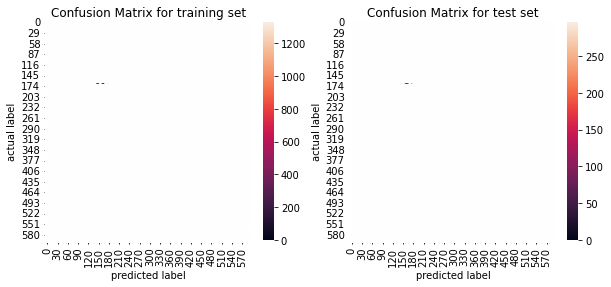

In [18]:
label = 'gl_approver' # define label here
train_model(label)

# gl_posting_id

Reduced to 28166 samples from 2 relevant classes. (N=5)
Fitting 10 folds for each of 8 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

{'C': 1, 'penalty': 'none', 'solver': 'saga'}
0.9852653132114885
Training Accuracy: 1.000
Test Accuracy: 0.987
              precision    recall  f1-score   support

          40       0.99      1.00      0.99      5335
          50       0.92      0.82      0.87       299

    accuracy                           0.99      5634
   macro avg       0.96      0.91      0.93      5634
weighted avg       0.99      0.99      0.99      5634



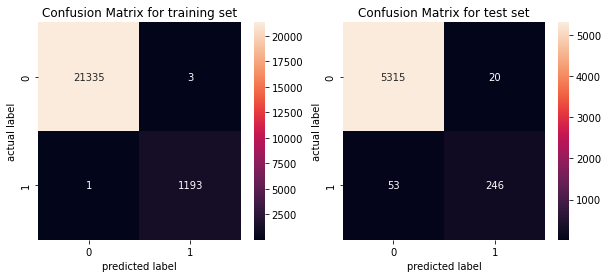

In [19]:
label = 'gl_posting_id' # define label here
train_model(label)